# Siamese neural network to classify fingerprints

In [125]:
from sklearn.model_selection import train_test_split
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt
import os
from skimage.transform import rescale


# Gets the training and test data and labels
def get_data():
    # http://bias.csr.unibo.it/fvc2004/Downloads/DB1_B.zip
    # 10 fingers, 8 images per finger
    dir = 'db1_b'
    X = []
    X_filename = []
    y = []
    for i, file in enumerate(os.listdir(dir)):
        if file.endswith('.tif'):
            im = plt.imread(dir + '/' + file)
            X.append(rescale(im, 0.25))
            y.append(file[1:3])
            X_filename.append(file.split('.')[0])
    X = np.asarray(X, dtype=np.float32)
    y = np.asarray(y, dtype=int)
    X_train, X_test, y_train, y_test, X_filename_train, X_filename_test = train_test_split(X, y, X_filename, stratify=y,
                                                                                           random_state=301)
    y_train_dict = defaultdict(list)
    for i, v in enumerate(y_train):
        y_train_dict[v].append(i)

    y_test_dict = defaultdict(list)
    for i, v in enumerate(y_test):
        y_test_dict[v].append(i)

    return X_train, X_test, y_train, y_test, y_train_dict, y_test_dict, X_filename_train, X_filename_test

In [126]:
import cv2
import imgaug.augmenters as iaa

#Augments the training data
def augment(X_train, X_filename_train, y_train):
    d = r'C:\Users\alexa\IdeaProjects\MSA301\project3\db1_b'
    X_train_augmented = []
    y_train_augmented = []
    for i in range(X_train.shape[0]):
        image = X_train[i]
        if not os.path.isdir(d + '\\' + X_filename_train[i]):
            os.mkdir(d + '\\' + X_filename_train[i])

        flip_vr = iaa.Flipud(p=1.0)
        flip_vr_image = flip_vr.augment_image(image)
        X_train_augmented.append(flip_vr_image)
        y_train_augmented.append(y_train[i])
        save_filename = d + '\\' + X_filename_train[i] + '\\' + X_filename_train[i] + "_flipped.png"
        cv2.imwrite(save_filename, flip_vr_image * 255)

        rotate = iaa.Affine(rotate=(50, -50))
        rotated_image = rotate.augment_image(image)
        X_train_augmented.append(rotated_image)
        y_train_augmented.append(y_train[i])
        save_filename = d + "/" + X_filename_train[i] + "/" + X_filename_train[i] + "_rotated1.png"
        cv2.imwrite(save_filename, rotated_image * 255)

        rotate = iaa.Affine(rotate=(50, -50))
        rotated_image = rotate.augment_image(image)
        X_train_augmented.append(rotated_image)
        y_train_augmented.append(y_train[i])
        save_filename = d + "/" + X_filename_train[i] + "/" + X_filename_train[i] + "_rotated2.png"
        cv2.imwrite(save_filename, rotated_image * 255)

        crop = iaa.Crop(percent=(0, 0.3))  # crop image
        crop_image = crop.augment_image(image)
        X_train_augmented.append(crop_image)
        y_train_augmented.append(y_train[i])
        save_filename = d + "/" + X_filename_train[i] + "/" + X_filename_train[i] + "_cropped1.png"
        cv2.imwrite(save_filename, crop_image * 255)

        crop = iaa.Crop(percent=(0, 0.3))  # crop image
        crop_image = crop.augment_image(image)
        X_train_augmented.append(crop_image)
        y_train_augmented.append(y_train[i])
        save_filename = d + "/" + X_filename_train[i] + "/" + X_filename_train[i] + "_cropped2.png"
        cv2.imwrite(save_filename, crop_image * 255)

        contrast = iaa.GammaContrast(gamma=2.0)
        contrast_image = contrast.augment_image(image)
        X_train_augmented.append(contrast_image)
        y_train_augmented.append(y_train[i])
        save_filename = d + "/" + X_filename_train[i] + "/" + X_filename_train[i] + "_bright1.png"
        cv2.imwrite(save_filename, contrast_image * 255)

        contrast = iaa.GammaContrast(gamma=1.4)
        contrast_image = contrast.augment_image(image)
        X_train_augmented.append(contrast_image)
        y_train_augmented.append(y_train[i])
        save_filename = d + "/" + X_filename_train[i] + "/" + X_filename_train[i] + "_bright2.png"
        cv2.imwrite(save_filename, contrast_image * 255)

        blur = iaa.GaussianBlur(sigma=4.0)
        blur_image = blur.augment_image(image)
        X_train_augmented.append(blur_image)
        y_train_augmented.append(y_train[i])
        save_filename = d + "/" + X_filename_train[i] + "/" + X_filename_train[i] + "_blur1.png"
        cv2.imwrite(save_filename, blur_image * 255)

        blur = iaa.GaussianBlur(sigma=2.0)
        blur_image = blur.augment_image(image)
        X_train_augmented.append(blur_image)
        y_train_augmented.append(y_train[i])
        save_filename = d + "/" + X_filename_train[i] + "/" + X_filename_train[i] + "_blur2.png"
        cv2.imwrite(save_filename, blur_image * 255)
    X_train_augmented = np.asarray(X_train_augmented)
    y_train_augmented = np.asarray(y_train_augmented)
    X_train_augmented = np.concatenate((X_train_augmented, X_train), axis=0)
    y_train_augmented = np.concatenate((y_train_augmented, y_train), axis=0)
    return X_train_augmented, y_train_augmented

In [127]:
#Creates pairs of images and labels
def make_pairs(X, y, return_ind=True, skip_self=False, return_class_tuples=False):
    samples_1 = []
    samples_2 = []
    labels = []
    classes = []
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            if i == j and skip_self:
                continue
            if not return_ind:
                samples_1.append(X[i])
                samples_2.append(X[j])
            else:
                samples_1.append(i)
                samples_2.append(j)
            labels.append(y[i] == y[j])
            if return_class_tuples:
                classes.append((y[i], y[j]))
    y_ = np.array(labels)
    X1 = np.array(samples_1)
    X2 = np.array(samples_2)
    if return_class_tuples:
        return X1, X2, y_, np.asarray(classes)
    else:
        return X1, X2, y_

In [128]:
#Functions to visualize training images
def visualize_data(X_train, y_train_dict):
    fig, axs = plt.subplots(3, 3, figsize=(6.4 * 1.5, 4.8 * 1.5))
    for i in range(1, 4):
        idx = y_train_dict[i]
        for j in range(3):
            axs[i - 1, j].imshow(X_train[idx[j]], cmap='gray')
            axs[i - 1, j].tick_params(which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
            if i == 1:
                axs[i - 1, j].set_title('Impression {}'.format(j + 1))
            if j == 0:
                axs[i - 1, j].set_ylabel('Finger {}'.format(i))
    plt.savefig('X_train_4_4.png')
    fig.suptitle('Training images')
    plt.show()
    fig, axs = plt.subplots(4, 2, figsize=(6.4, 4.8 * 1.5))
    idx = y_train_dict[1]
    for i in range(4):
        idx2 = y_train_dict[i + 1]
        axs[i, 0].imshow(X_train[idx[0]], cmap='gray')
        axs[i, 0].set_title('Finger {}'.format(1))
        axs[i, 0].tick_params(which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
        axs[i, 1].imshow(X_train[idx2[1]], cmap='gray')
        axs[i, 1].set_title('Finger {}'.format(i + 1))
        axs[i, 1].tick_params(which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
    fig.suptitle('Training pairs')
    plt.savefig('X_train_pairs.png')
    plt.show()


def visualize_augmented_data():
    d = 'db1_b'
    f = d + '/101_2.tif'
    real = plt.imread(f)
    augmented = []
    augmentation = []
    for file in os.listdir(d + '/101_2'):
        im = plt.imread(d + '/101_2/' + file)
        augmented.append(im)
        augmentation.append(file.split('_')[2].split('.')[0])
    fig, axs = plt.subplots(3, 3, figsize=(6.4 * 1.5, 4.8 * 1.5))
    for i in range(3):
        for j in range(3):
            if i == 0 and j == 0:
                axs[i, j].imshow(real, cmap='gray')
                axs[i, j].set_title('Original image')
                axs[i, j].tick_params(which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
                continue
            axs[i, j].imshow(augmented[i * 3 + j], cmap='gray')
            axs[i, j].tick_params(which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
            axs[i, j].set_title(augmentation[i * 3 + j].capitalize())
    fig.suptitle('Original image and augmented versions')
    plt.savefig('X_train_augmented_3x3')
    plt.show()

In [129]:
import tensorflow

class CustomGenerator(tensorflow.keras.utils.Sequence):
    # Generates batches for training given indices.
    # This is done because I was unable to store the array
    # of training data as images due to memory constraints

    def __init__(self, x_set, y_set, batch_size, images):
        self.X_1 = x_set[0]
        self.X_2 = x_set[1]
        self.labels = y_set
        self.batch_size = batch_size
        self.images = images

    def __len__(self):
        return (np.ceil(len(self.X_1) / float(self.batch_size))).astype(np.int)

    def __getitem__(self, idx):
        X_1_batch = self.X_1[idx * self.batch_size: (idx + 1) * self.batch_size]
        X_2_batch = self.X_2[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size: (idx + 1) * self.batch_size]

        return [self.images[X_1_batch], self.images[X_2_batch]], np.array(batch_y)


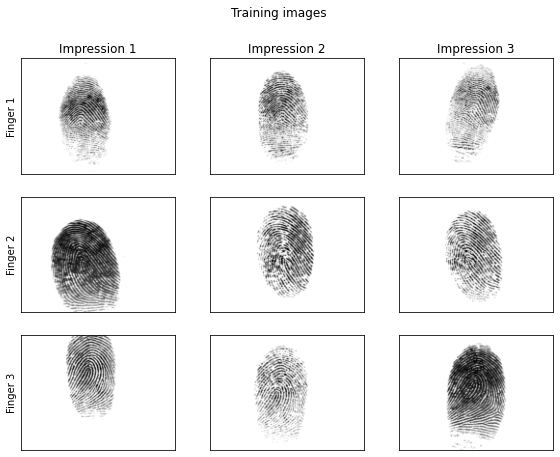

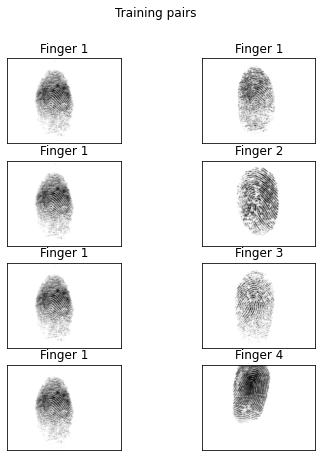

In [130]:
X_train, X_test, y_train, y_test, y_train_dict, y_test_dict, X_filename_train, X_filename_test = get_data()
X_train_augmented, y_train_augmented = augment(X_train, X_filename_train, y_train)
visualize_data(X_train, y_train_dict)

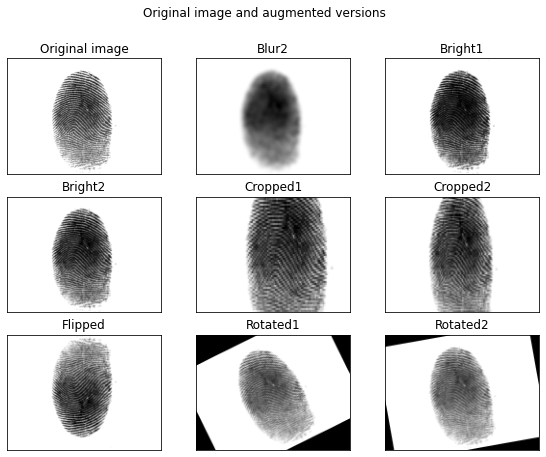

In [131]:
visualize_augmented_data()

In [132]:
#The indices of the images since it is too large to store in memory
X1, X2, y = make_pairs(X_train_augmented, y_train_augmented, return_ind=True, skip_self=True)
#The actual images
X1_2, X2_2, y2 = make_pairs(X_train, y_train, return_ind=False, skip_self=True)
print('Augmented train', X1.shape, 'Unaugmented train', X1_2.shape)

Augmented train (359400,) Unaugmented train (3540, 120, 160)


In [133]:
from tensorflow.python.keras.utils.vis_utils import plot_model
import time
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras import activations, Input, models, losses
from tensorflow.python.keras.layers import Reshape, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.python.keras.backend import abs, set_value


class Recognizer(object):

    # initializes the model
    def __init__(self):

        input_shape = (120 * 160,)
        convolution_shape = (120, 160, 1)
        kernel_size_1 = (10, 10)
        kernel_size_2 = (7, 7)
        kernel_size_3 = (4, 4)

        seq_conv_model = [

            Reshape(input_shape=input_shape, target_shape=convolution_shape),

            Conv2D(64, kernel_size=kernel_size_1, activation='relu'),
            MaxPooling2D(strides=2),

            Conv2D(128, kernel_size=kernel_size_2, activation='relu'),
            MaxPooling2D(strides=2),

            Conv2D(128, kernel_size=kernel_size_3, activation='relu'),
            MaxPooling2D(strides=2),

            Conv2D(256, kernel_size=kernel_size_3, activation='relu'),
            Flatten(),

            Dense(1024, activation='relu'),
            Dense(1024, activation='sigmoid')

        ]

        seq_model = Sequential(seq_conv_model)
        plot_model(seq_model, 'sequential.png', show_shapes=True, show_layer_names=True)

        input_x1 = Input(shape=input_shape)
        input_x2 = Input(shape=input_shape)

        output_x1 = seq_model(input_x1)
        output_x2 = seq_model(input_x2)

        distance_euclid = Lambda(lambda tensors: abs(tensors[0] - tensors[1]), name='subtract')(
            [output_x1, output_x2])
        outputs = Dense(1, activation=activations.sigmoid)(distance_euclid)
        self.__model = models.Model([input_x1, input_x2], outputs)

        self.__model.compile(loss=losses.binary_crossentropy, optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00006))

    # trains the model
    def fit(self, X, Y, hyperparameters):
        initial_time = time.time()
        hist = self.__model.fit(X, Y,
                                batch_size=hyperparameters['batch_size'],
                                epochs=hyperparameters['epochs'],
                                callbacks=hyperparameters['callbacks'],
                                validation_data=hyperparameters['val_data']
                                )
        final_time = time.time()
        eta = (final_time - initial_time)
        time_unit = 'seconds'
        if eta >= 60:
            eta = eta / 60
            time_unit = 'minutes'
        self.__model.summary()
        print('Elapsed time acquired for {} epoch(s) -> {} {}'.format(hyperparameters['epochs'], eta, time_unit))
        return hist.history

    def evaluate(self, X, y):
        results = self.__model.evaluate(X, y)
        return results

    # trains the model
    def fit_generator(self, generator, hyperparameters):
        initial_time = time.time()
        hist = self.__model.fit(x=generator,
                                epochs=hyperparameters['epochs'],
                                callbacks=hyperparameters['callbacks'],
                                validation_data=hyperparameters['val_data'],
                                steps_per_epoch=hyperparameters['steps_per_epoch']
                                )
        final_time = time.time()
        eta = (final_time - initial_time)
        time_unit = 'seconds'
        if eta >= 60:
            eta = eta / 60
            time_unit = 'minutes'
        self.__model.summary()
        print('Elapsed time acquired for {} epoch(s) -> {} {}'.format(hyperparameters['epochs'], eta, time_unit))
        return hist.history

    # gives the model prediction for the given input
    def predict(self, X):
        predictions = self.__model.predict(X)
        return predictions

    # gives the model parameters
    def summary(self):
        self.__model.summary()

    # saves the model to the specified filepath
    def save_model(self, file_path):
        self.__model.save(file_path)

    # loads the model from the specified path
    def load_model(self, file_path, compile=True):
        self.__model = models.load_model(file_path, compile=compile)

    def save(self, file_path):
        self.__model.save(file_path)

    def set_learning_rate(self, learning_rate):
        set_value(self.__model.optimizer.learning_rate, learning_rate)

    def plot_model(self, file_name):
        plot_model(self.__model, to_file=file_name, show_shapes=True, show_layer_names=True)

    def input(self):
        return self.__model.input

    def layers(self):
        return self.__model.layers


In [134]:
import pickle
from tensorflow.python.keras.callbacks import ModelCheckpoint


def train_model(siamese2, X1_2, X2_2, y2, batch_size=64):
    checkpointer2 = ModelCheckpoint(filepath='siamese2.h5', monitor='loss', verbose=1, save_best_only=True)
    hyperparameters2 = {'epochs': 30, 'batch_size': batch_size, 'callbacks': checkpointer2, 'val_data': None}
    history = siamese2.fit([X1_2.reshape(X1_2.shape[0], 120 * 160), X2_2.reshape(X2_2.shape[0], 120 * 160)], y2,
                           hyperparameters=hyperparameters2)
    with (open('history_siamese2_2.pkl', 'wb')) as file:
        pickle.dump(history, file)


def train_model2(siamese3, X1, X2, y, X_train_augmented, batch_size=64):
    checkpointer = ModelCheckpoint(filepath='siamese3.h5', monitor='loss', verbose=1, save_best_only=True)
    hyperparameters = {'epochs': 4, 'steps_per_epoch': X1.shape[0] // batch_size, 'callbacks': checkpointer,
                       'val_data': None}
    training_generator = CustomGenerator([X1, X2], y, batch_size,
                                         X_train_augmented.reshape(X_train_augmented.shape[0], 120 * 160))
    history = siamese3.fit_generator(training_generator, hyperparameters=hyperparameters)
    with (open('history_siamese3_4.pkl', 'wb')) as file:
        pickle.dump(history, file)

In [135]:
def plot_losses(history):
    loss = history['loss']
    plt.plot(np.arange(len(loss)), loss, '.-')
    plt.title('Loss over epochs')
    plt.savefig('loss_siamese2.png')
    plt.show()

### Model trained on un-augmented data

In [136]:
siamese2 = Recognizer()
siamese2.load_model('siamese2.h5')
# train_model(siamese2, X1_2, X2_2, y2)

c:\users\alexa\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\layers\core.py:1059: UserWarning: project3.recognizer is not loaded, but a Lambda layer uses it. It may cause errors.
  warnings.warn('{} is not loaded, but a Lambda layer uses it. '


In [148]:
from sklearn.metrics import confusion_matrix

with open('history_siamese2_2.pkl', 'rb') as file:
    history_siamese2 = pickle.load(file)
X1_test, X2_test, y2_test, classes_test = make_pairs(X_test, y_test, skip_self=True, return_class_tuples=True,
                                                     return_ind=False)
pred = siamese2.predict(
    [X1_test.reshape(X1_test.shape[0], 120 * 160), X2_test.reshape(X2_test.shape[0], 120 * 160)])
y_pred = np.round(pred)
tn, fp, fn, tp = confusion_matrix(y2_test, y_pred).ravel()
print('Specificity', tn / (tn + fp))
print('Sensitivity', tp / (tp + fn))
print('F1', tp / (tp + (fp + fn) / 2))

Specificity 0.9722222222222222
Sensitivity 0.1
F1 0.125


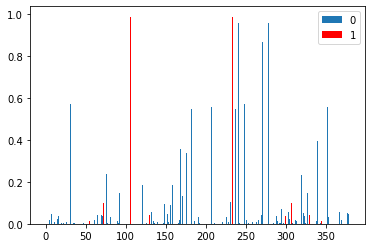

In [138]:
plt.bar(x=np.arange(pred.shape[0]), height=pred.ravel(), label='0')
plt.bar(x=np.arange(pred.shape[0])[y2_test], height=pred.ravel()[y2_test], color='red', label='1')
plt.legend()
plt.savefig('siamese2_pred_bar.png')
plt.show()

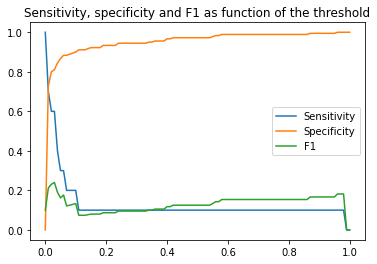

In [149]:
lin = np.linspace(0, 1, 101)
sens = np.zeros(101)
spec = np.zeros(101)
f1 = np.zeros(101)
for i, l in enumerate(lin):
    pred2 = pred >= l
    tn, fp, fn, tp = confusion_matrix(y2_test, pred2).ravel()
    sens[i] = tp / (tp + fn)
    spec[i] = tn / (tn + fp)
    f1[i] = tp / (tp + (fp + fn) / 2)
plt.plot(lin, sens, label='Sensitivity')
plt.plot(lin, spec, label='Specificity')
plt.plot(lin, f1, label='F1')
plt.title('Sensitivity, specificity and F1 as function of the threshold')
plt.savefig('siamese2_threshold.png')
plt.legend()
plt.show()

In [150]:
idx = np.where(spec >= sens)[0][0]
threshold = lin[idx]
print('threshold siamese2', threshold)
pred3 = pred >= threshold
tn, fp, fn, tp = confusion_matrix(y2_test, pred3).ravel()
print('Specificity threshold siamese2', tn / (tn + fp))
print('Sensitivity threshold siamese2', tp / (tp + fn))
print('F1 threshold siamese2', tp / (tp + (fp + fn) / 2))

threshold siamese2 0.01
Specificity threshold siamese2 0.7277777777777777
Sensitivity threshold siamese2 0.7
F1 threshold siamese2 0.21212121212121213


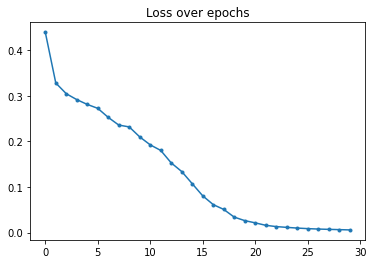

In [151]:
plot_losses(history_siamese2)

### Model trained on augmented data

In [141]:
siamese3 = Recognizer()
siamese3.plot_model('siamese_model3.png')
siamese3.load_model('siamese3.h5')
print(siamese3.summary())

# train_model2(siamese3, X1, X2, y2, X_train_augmented)

c:\users\alexa\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\layers\core.py:1059: UserWarning: project3.recognizer is not loaded, but a Lambda layer uses it. It may cause errors.
  warnings.warn('{} is not loaded, but a Lambda layer uses it. '


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 19200)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 19200)]      0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1024)         24265536    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
subtract (Lambda)               (None, 1024)         0           sequential[0][0]             

In [142]:
# X1_test, X2_test, y2_test, classes_test = make_pairs(X_test, y_test, skip_self=True, return_class_tuples=True,
#                                                      return_ind=False)

pred = siamese3.predict(
    [X1_test.reshape(X1_test.shape[0], 120 * 160), X2_test.reshape(X2_test.shape[0], 120 * 160)])
y_pred = np.round(pred)
tn, fp, fn, tp = confusion_matrix(y2_test, y_pred).ravel()
print('Specificity', tn / (tn + fp))
print('Sensitivity', tp / (tp + fn))
print('F1', tp / (tp + (fp + fn) / 2))
ind = np.argpartition(pred.ravel(), -8)[-8:]
print('Finger pairs with highest probability', classes_test[ind], pred[ind])

Specificity 0.9444444444444444
Sensitivity 0.0
F1 0.0
Finger pairs with highest probability [[ 6  8]
 [10  9]
 [ 1  6]
 [ 2  7]
 [ 9 10]
 [ 7  2]
 [ 6  1]
 [ 8  6]] [[0.9481593]
 [0.9704283]
 [0.9829389]
 [0.9705145]
 [0.9704283]
 [0.9705193]
 [0.9829389]
 [0.9481593]]


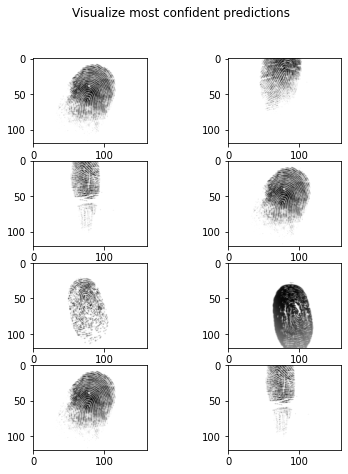

In [152]:
fig, axs = plt.subplots(4, 2, figsize=(6.4, 4.8 * 1.5))
for i in range(4):
    axs[i, 0].imshow(X1_test[ind[i * 2]], cmap='gray')
    axs[i, 1].imshow(X2_test[ind[i * 2]], cmap='gray')
fig.suptitle('Visualize most confident predictions')
plt.show()

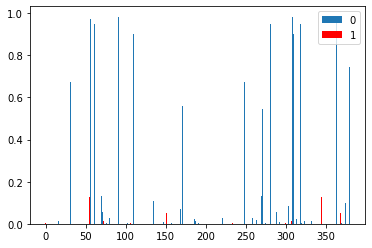

In [144]:
plt.bar(x=np.arange(pred.shape[0]), height=pred.ravel(), label='0')
plt.bar(x=np.arange(pred.shape[0])[y2_test], height=pred.ravel()[y2_test], color='red', label='1')
plt.legend()
plt.savefig('siamese3_pred_bar.png')
plt.show()

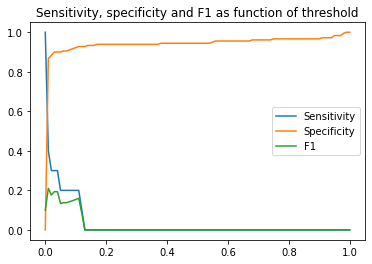

In [145]:
lin = np.linspace(0, 1, 101)
sens = np.zeros(101)
spec = np.zeros(101)
f1 = np.zeros(101)
for i, l in enumerate(lin):
    pred2 = pred >= l
    tn, fp, fn, tp = confusion_matrix(y2_test, pred2).ravel()
    sens[i] = tp / (tp + fn)
    spec[i] = tn / (tn + fp)
    f1[i] = tp / (tp + (fp + fn) / 2)
plt.plot(lin, sens, label='Sensitivity')
plt.plot(lin, spec, label='Specificity')
plt.plot(lin, f1, label='F1')
plt.title('Sensitivity, specificity and F1 as function of threshold')
plt.legend()
plt.savefig('siamese3_threshold.png')
plt.show()

In [146]:
def plot_losses2():
    # cancelled the first training run after only one epoch had finished
    # which meant the history wasnt pickled so i manually saved the loss of the first epoch
    losses = [0.3008]
    for i in range(2, 5):
        with open('history_siamese3_{}.pkl'.format(i), 'rb') as file:
            history = pickle.load(file)
            losses.extend(history['loss'])
    plt.plot(np.arange(len(losses)), losses, '.-')
    plt.title('Loss over epochs')
    plt.savefig('loss_siamese3.png')
    plt.show()

Specificity threshold siamese3 0.8666666666666667
Sensitivity threshold siamese3 0.4
F1 threshold siamese3 0.21052631578947367
threshold siamese3 0.01


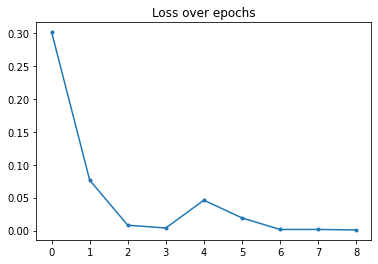

In [147]:
idx = np.where(spec >= sens)
idx = idx[0][0]
threshold = lin[idx]
pred3 = pred >= threshold
tn, fp, fn, tp = confusion_matrix(y2_test, pred3).ravel()
print('Specificity threshold siamese3', tn / (tn + fp))
print('Sensitivity threshold siamese3', tp / (tp + fn))
print('F1 threshold siamese3', tp / (tp + (fp + fn) / 2))
print('threshold siamese3', threshold)

plot_losses2()

Overall, this project was not very succesful for a number of reasons. This was a project for a course in spatial statistics and image analysis and as such I did not have much time to work on it.

The main issues lie in the choice of loss function and amount of augmentation. I believe that using a contrastive loss would have given better results. The amount of augmentation was probably too large as well as we saw that using augmented data resulted in worse performance.